### Import modules

In [283]:

import pandas as pd
import numpy as np
import pickle as pkl

#Image analysis
import cv2

#UNIX and OS functionality
import os, glob

#Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn models
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection as f_select
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Dummy Classifier
from sklearn.dummy import DummyClassifier

#Resampling algorithm
import imblearn.over_sampling

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


%matplotlib inline

### Functions

In [185]:
def make_HUmoments(image_path):
    '''
    Hu Moments are used to characterize the outline 
    or “silhouette” of an object in an image.USe open cv2 to 
    conver the color image to a greyscale version and
    calcualte its 24 moments followed by flattening it out to 7
    '''
    img1 = cv2.imread(image_path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_hum = cv2.HuMoments(cv2.moments(img2)).flatten()
    return img2_hum 

def get_moments_df(base_tile_dir):
    '''
    Creates a data frame with the 
    '''
    dataframe = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
    dataframe['cell_type'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
    dataframe['cell_type_idx'] = dataframe['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
    dataframe['image_name'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
    dataframe['image_row'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
    dataframe['image_col'] = dataframe['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
    dataframe['image'] = dataframe['path'].map(make_HUmoments)
    dataframe[['moment1','moment2', 'moment3','moment4', 'moment5','moment6','moment7']] = pd.DataFrame(dataframe.image.values.tolist(), index= dataframe.index)
    return dataframe

def best_F1_finder(lower, higher, model):
    X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

    thresh_ps = np.linspace(lower,higher,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores = []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(model_val_labels, y_val))

    plt.plot(thresh_ps, f1_scores)
    plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
    plt.xlabel('P threshold')
    plt.ylabel('F1 score')

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))
    
def test_logistic(X_train, y_train, X_test, y_test):
    lr = LogisticRegression(solver = 'lbfgs') 
    lr.fit(X_train, y_train)
    print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
      
def test_logistic_oversampling(X_train, y_train, X_test, y_test, factor = 1):
    a = y_train.value_counts()[0]
    b = y_train.value_counts()[1]
    factor = a//b
    ROS_log = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:a,1:b*factor}, \
                                               random_state=42) 
    
    X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

    lr_os = LogisticRegression(solver = 'lbfgs') 
    lr_os.fit(X_tr_rs, y_tr_rs)

    print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
          (f1_score(lr_os.predict(X_test), y_test), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))
    
    
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [ ]:
base_tile_dir = './colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/'

### Testing code

In [2]:
img1 = cv2.imread('colorectal-histology-mnist/Kather_texture_2016_image_tiles_5000/01_TUMOR/3CDD_CRC-Prim-HE-02_025.tif_Row_151_Col_151.tif')

In [3]:
img1.shape

(150, 150, 3)

In [5]:
img1.size

67500

In [7]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [9]:
img2.shape

(150, 150)

In [11]:
img2.size

22500

In [12]:
img2_hum = cv2.HuMoments(cv2.moments(img2)).flatten()

In [13]:
img2_hum

array([1.28335721e-03, 5.53804277e-09, 9.30964314e-12, 3.98283946e-11,
       1.18832751e-22, 2.72872759e-15, 7.57667725e-22])

In [17]:
print(os.getcwd())

/Users/Swami/ds/metis/metisgh/Project-McNulty/Colorectal_cancer


In [187]:
base_tile_dir = './colorectal-histology-mnist/kather_texture_2016_image_tiles_5000/'
df = pd.DataFrame({'path': glob.glob(os.path.join(base_tile_dir, '*', '*.tif'))}) 
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[1])
df['cell_type_idx'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x)).split('_')[0])
df['image_name'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[0])
df['image_row'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[1])
df['image_col'] = df['path'].map(lambda x: os.path.basename(x).split('_Row')[1].split('_')[3].split('.')[0])
df['image'] = df['path'].map(make_HUmoments)
df[['moment1','moment2', 'moment3','moment4', 'moment5','moment6','moment7']] = pd.DataFrame(df.image.values.tolist(), index= df.index)
df.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image,moment1,moment2,moment3,moment4,moment5,moment6,moment7
1854,./colorectal-histology-mnist/kather_texture_20...,COMPLEX,03,74FE_CRC-Prim-HE-05_012.tif,151,1,"[0.001514698194536964, 6.390511730816183e-11, ...",0.001515,6.390512e-11,1.672750e-11,1.043145e-12,2.503250e-24,5.358382e-18,3.566665e-24
4979,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,15613_CRC-Prim-HE-06_005.tif,5551,1501,"[0.0006956355928539014, 2.0185821616911658e-13...",0.000696,2.018582e-13,4.655896e-16,9.559112e-17,1.900896e-32,1.902945e-23,6.733672e-33
2030,./colorectal-histology-mnist/kather_texture_20...,LYMPHO,04,15011_CRC-Prim-HE-06.tif,1,151,"[0.0018267752669325313, 1.7306286922744873e-08...",0.001827,1.730629e-08,2.513604e-11,5.627979e-12,4.984548e-23,-2.573803e-16,4.467900e-23
675,./colorectal-histology-mnist/kather_texture_20...,STROMA,02,104ED_CRC-Prim-HE-03_011.tif,301,301,"[0.001771713000535128, 5.9623089125005444e-09,...",0.001772,5.962309e-09,1.769895e-11,5.190638e-12,-4.495468e-23,-2.219519e-16,2.131370e-23
3006,./colorectal-histology-mnist/kather_texture_20...,DEBRIS,05,5F74_CRC-Prim-HE-08_023.tif,751,451,"[0.000928363415517372, 1.9702539623295604e-09,...",0.000928,1.970254e-09,2.411650e-12,4.339879e-12,3.163083e-24,-7.085148e-17,-1.367927e-23


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
path             5000 non-null object
cell_type        5000 non-null object
cell_type_idx    5000 non-null object
image_name       5000 non-null object
image_row        5000 non-null object
image_col        5000 non-null object
image            5000 non-null object
moment1          5000 non-null float64
moment2          5000 non-null float64
moment3          5000 non-null float64
moment4          5000 non-null float64
moment5          5000 non-null float64
moment6          5000 non-null float64
moment7          5000 non-null float64
dtypes: float64(7), object(7)
memory usage: 547.0+ KB


In [189]:
df.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image,moment1,moment2,moment3,moment4,moment5,moment6,moment7
724,./colorectal-histology-mnist/kather_texture_20...,STROMA,02,10AEA_CRC-Prim-HE-02_011.tif,1,751,"[0.0010258155492986298, 1.6031478102222616e-10...",0.001026,1.603148e-10,4.356319e-13,1.649909e-13,-4.178599e-27,1.463147e-18,-4.403554e-26
4093,./colorectal-histology-mnist/kather_texture_20...,ADIPOSE,07,13E1E_CRC-Prim-HE-03_012.tif,1501,1051,"[0.0007506828920548743, 1.538594402597925e-10,...",0.000751,1.538594e-10,2.355061e-13,1.289425e-13,-1.988282e-26,-1.501420e-18,1.046691e-26
407,./colorectal-histology-mnist/kather_texture_20...,TUMOR,01,4782_CRC-Prim-HE-09_009.tif,151,151,"[0.002175533635883696, 2.609610769924637e-10, ...",0.002176,2.609611e-10,2.528724e-12,1.439785e-12,2.204893e-24,-5.648683e-18,1.638839e-24
4972,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,153DE_CRC-Prim-HE-06_005.tif,3451,1,"[0.0006866761100739957, 1.928920512792153e-13,...",0.000687,1.928921e-13,1.334829e-16,2.576091e-16,-4.663885e-32,-8.596668e-23,1.033362e-32
3610,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,184CE_CRC-Prim-HE-06_032.tif,751,601,"[0.0021485655322249584, 3.4227621455087306e-08...",0.002149,3.422762e-08,2.297627e-10,1.515919e-12,2.569198e-23,2.768277e-16,-1.184580e-23


In [190]:
df['y'] = df.cell_type.map({'MUCOSA':0, 'DEBRIS':0, 'ADIPOSE':0,'EMPTY':0,'STROMA':0,'COMPLEX':0, 'LYMPHO':0,'TUMOR':1})

In [191]:
df.sample(5)

,path,cell_type,cell_type_idx,image_name,image_row,image_col,image,moment1,moment2,moment3,moment4,moment5,moment6,moment7,y
172,./colorectal-histology-mnist/kather_texture_20...,TUMOR,01,15348_CRC-Prim-HE-02_003.tif,1,301,"[0.002101760622485967, 3.3020857873719844e-08,...",0.002102,3.302086e-08,1.308702e-11,7.766974e-11,2.084906e-21,-1.374224e-14,1.336070e-21,1
3492,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,165B1_CRC-Prim-HE-09_001.tif,1801,151,"[0.001428138489972084, 9.852140826339663e-10, ...",0.001428,9.852141e-10,1.861640e-11,4.074773e-11,7.398807e-22,1.275096e-15,-8.438596e-22,0
972,./colorectal-histology-mnist/kather_texture_20...,STROMA,02,127B2_CRC-Prim-HE-03_008.tif,301,451,"[0.0009484849599113731, 1.5653310594573922e-09...",0.000948,1.565331e-09,3.898475e-13,8.436101e-14,1.329708e-26,-3.079585e-18,-7.565968e-27,0
4947,./colorectal-histology-mnist/kather_texture_20...,EMPTY,08,150D9_CRC-Prim-HE-06_005.tif,6151,6751,"[0.0006866969877900112, 1.4198676452619071e-15...",0.000687,1.419868e-15,1.257417e-17,5.478401e-17,-1.364932e-33,-1.625779e-24,-4.521495e-34,0
3460,./colorectal-histology-mnist/kather_texture_20...,MUCOSA,06,15F90_CRC-Prim-HE-03_006.tif,601,1201,"[0.0012361704640430583, 1.5466960244226887e-09...",0.001236,1.546696e-09,1.078726e-11,1.418101e-11,1.752596e-22,3.615479e-16,-6.878839e-24,0


In [192]:
df_test = df.loc[:,'moment1':'y']

In [193]:
df_test.head(5)

,moment1,moment2,moment3,moment4,moment5,moment6,moment7,y
0,0.002303,2.033356e-08,1.076167e-10,6.457847e-11,-2.787484e-21,9.206237e-15,4.605748e-21,1
1,0.003158,5.799728e-08,2.132204e-10,3.160068e-11,-2.583687e-21,-7.061767e-15,-2.303412e-22,1
2,0.002251,7.314273e-08,1.398969e-11,4.572727e-11,-9.127302e-22,-4.052109e-16,-7.103148e-22,1
3,0.002419,3.801423e-08,7.848209e-14,5.117517e-12,-2.980195e-24,9.977587e-16,1.279377e-24,1
4,0.002114,1.637051e-08,6.107033e-11,4.111435e-11,-1.967104e-21,1.648033e-15,6.122465e-22,1


In [11]:
df_test.columns

Index(['moment1', 'moment2', 'moment3', 'moment4', 'moment5', 'moment6',
       'moment7', 'y'],
      dtype='object')

### Variance Inflation Factor

In [12]:
X = add_constant(df_test)
pd.Series([np.sqrt(variance_inflation_factor(X.values, i)) 
               for i in range(X.shape[1])], 
              index=X.columns)

const      2.499409
moment1    1.208150
moment2    1.349882
moment3    1.247469
moment4    1.669210
moment5    1.169559
moment6    1.620823
moment7    1.041361
y          1.163699
dtype: float64

### Feature Visualization

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


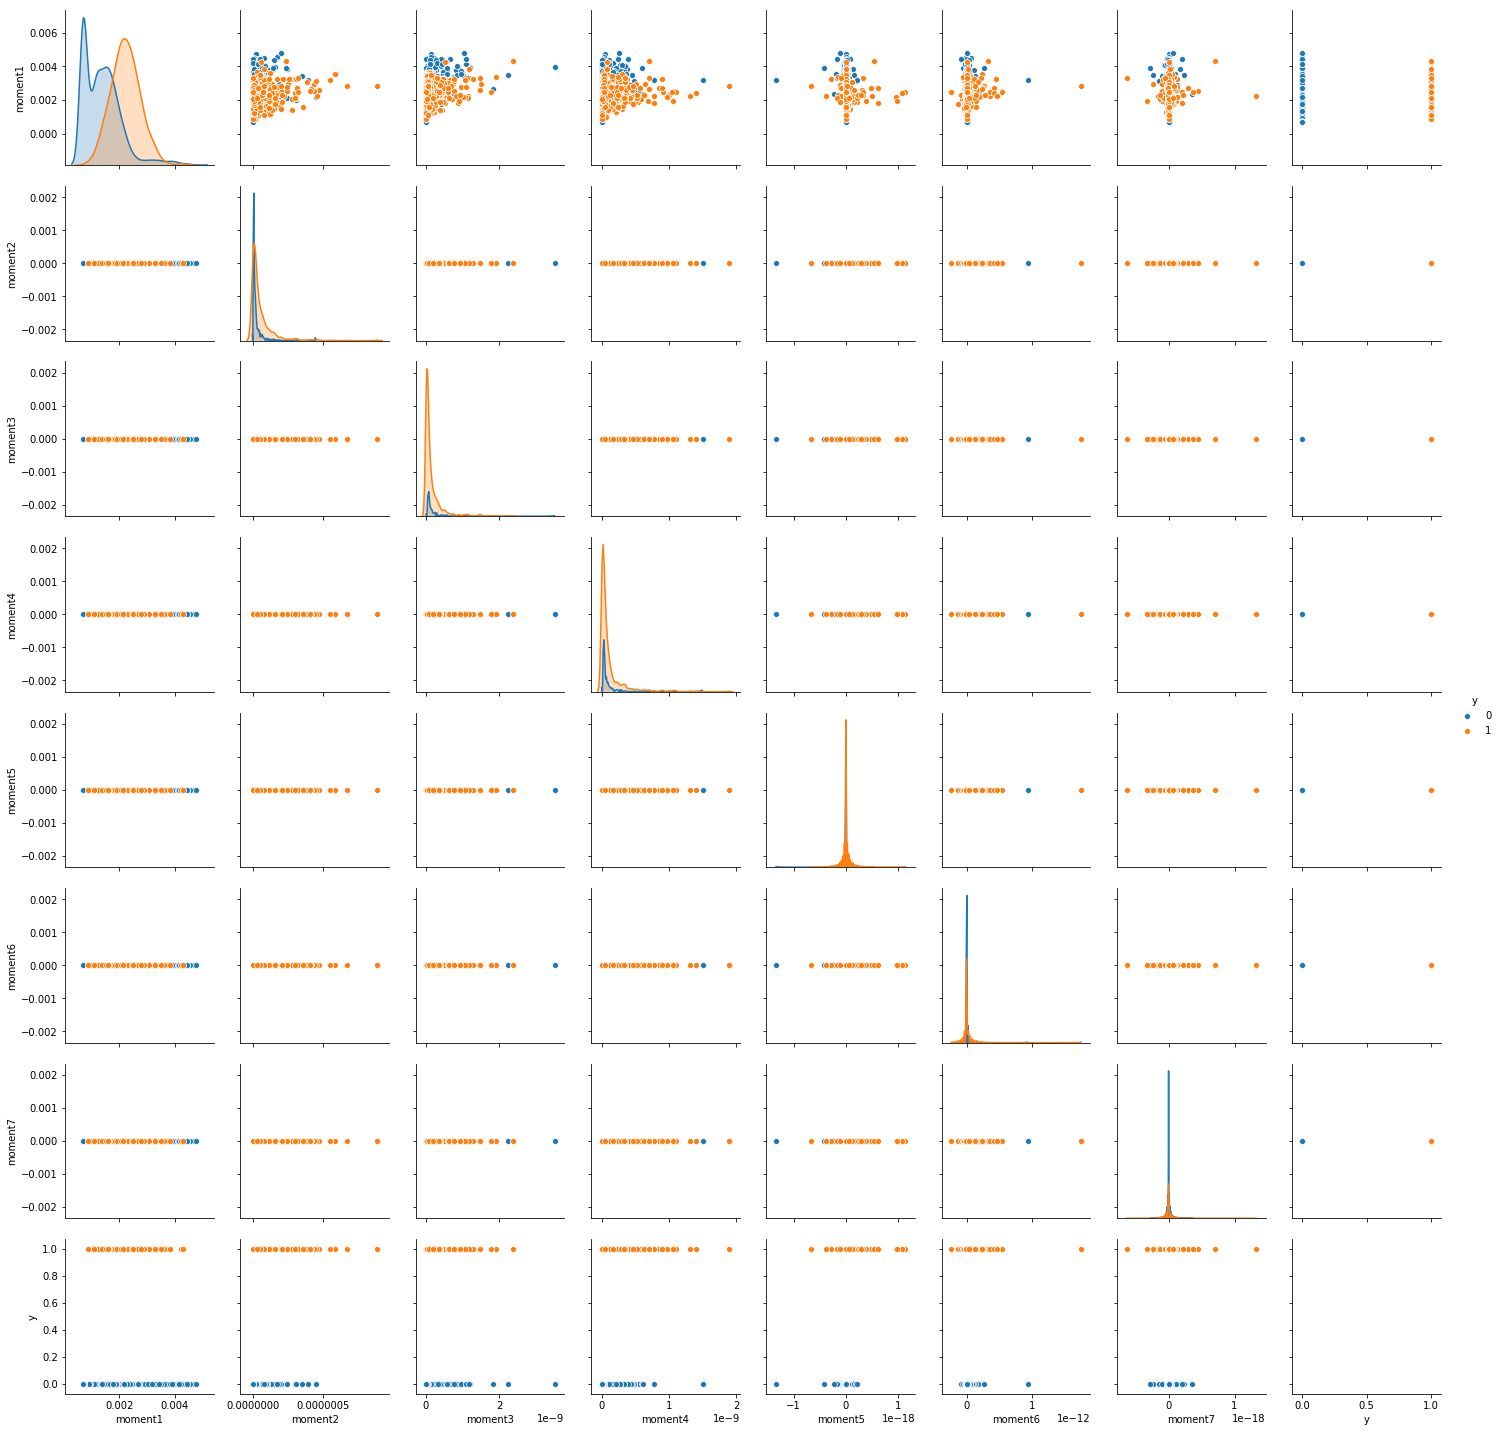

In [82]:
sns.pairplot(df_test, hue = 'y')

In [194]:
X =  df.loc[:,'moment1':'moment7']
y = df['y']

ssX = StandardScaler()
X_scaled = ssX.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = ['moment1', 'moment2', 'moment3', 'moment4', 'moment5', 'moment6',
       'moment7'])

In [195]:
X.head()

,moment1,moment2,moment3,moment4,moment5,moment6,moment7
0,0.002303,2.033356e-08,1.076167e-10,6.457847e-11,-2.787484e-21,9.206237e-15,4.605748e-21
1,0.003158,5.799728e-08,2.132204e-10,3.160068e-11,-2.583687e-21,-7.061767e-15,-2.303412e-22
2,0.002251,7.314273e-08,1.398969e-11,4.572727e-11,-9.127302e-22,-4.052109e-16,-7.103148e-22
3,0.002419,3.801423e-08,7.848209e-14,5.117517e-12,-2.980195e-24,9.977587e-16,1.279377e-24
4,0.002114,1.637051e-08,6.107033e-11,4.111435e-11,-1.967104e-21,1.648033e-15,6.122465e-22


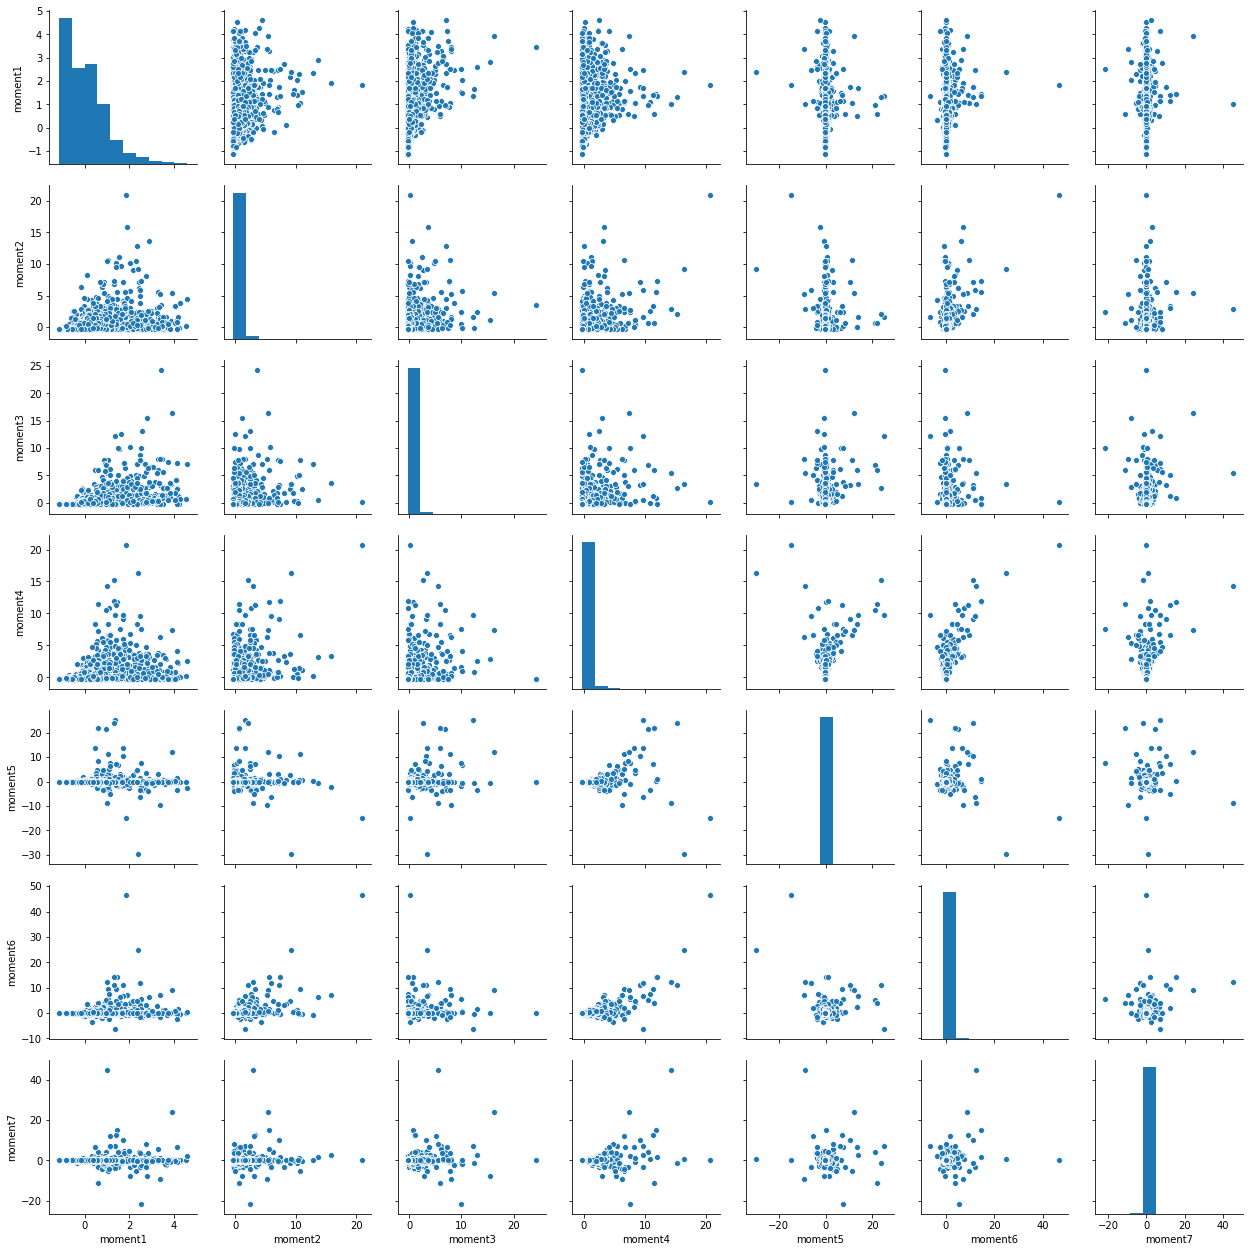

In [91]:
sns.pairplot(X_scaled)

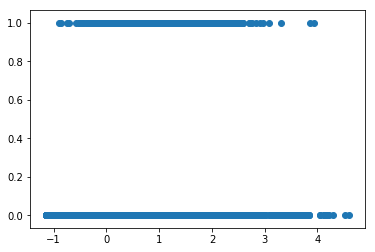

In [101]:
plt.scatter(X_scaled['moment1'], y);

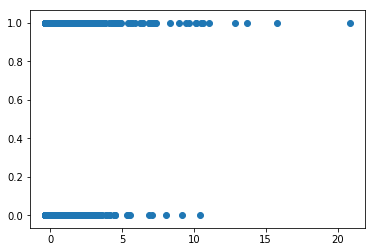

In [102]:
plt.scatter(X_scaled['moment2'], y);

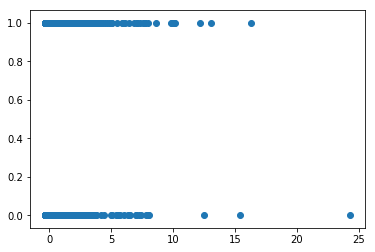

In [103]:
plt.scatter(X_scaled['moment3'], y);

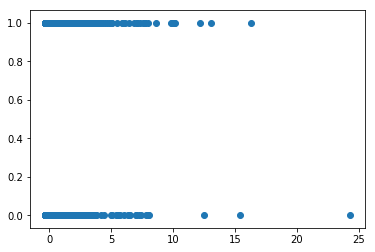

In [104]:
plt.scatter(X_scaled['moment3'], y);

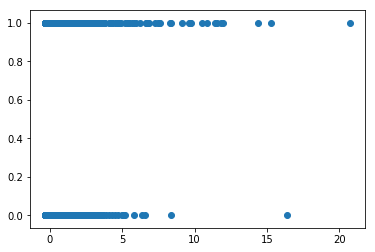

In [105]:
plt.scatter(X_scaled['moment4'], y);

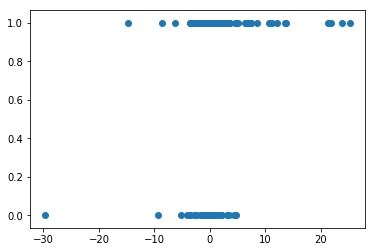

In [106]:
plt.scatter(X_scaled['moment5'], y);

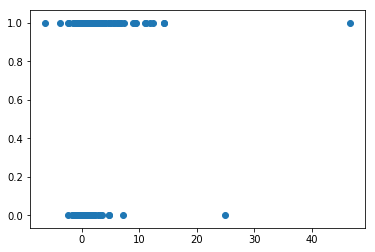

In [107]:
plt.scatter(X_scaled['moment6'], y);

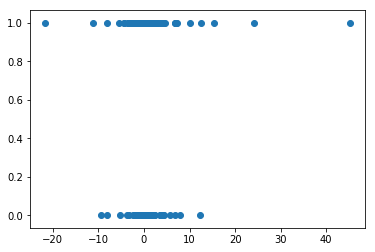

In [108]:
plt.scatter(X_scaled['moment7'], y);

### p-value to check the feature importance

In [15]:
est=LogisticRegression(solver = 'lbfgs')
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[] # will be the list of all significant columns' p-values

for feature in X.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(df_test[[feature]],df_test.y) # univariate regression for feature selection ; gets f-value and p-value scores
    print(pval)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
df_new_trans=df_test[sig_columns]

cross_val_score(est,df_new_trans,df_test.y,cv=5,scoring='accuracy').mean()

(array([904.36132717]), array([9.07322204e-183]))
(array([865.43533805]), array([1.40318154e-175]))
(array([491.08066718]), array([7.2129662e-104]))
(array([696.00287336]), array([1.02647413e-143]))
(array([66.45330641]), array([4.48912778e-16]))
(array([127.11910303]), array([3.92235973e-29]))
(array([18.6962925]), array([1.56263086e-05]))


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.875

In [16]:
sig_columns

['moment1', 'moment2', 'moment3', 'moment4', 'moment5', 'moment6', 'moment7']

### Resampling data

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [197]:
X_train.head()

,moment1,moment2,moment3,moment4,moment5,moment6,moment7
1840,0.001432,1.678061e-09,1.955871e-12,1.451098e-12,-2.436524e-24,-3.312694e-17,1.990713e-25
2115,0.004102,4.883356e-08,4.284422e-10,3.851262e-11,3.201455e-21,4.517826e-15,3.771536e-21
4437,0.000686,1.438505e-13,1.182269e-16,2.654729e-17,7.875461e-34,-7.142203e-24,-1.261638e-33
1146,0.001783,3.443639e-09,5.833802e-12,1.229571e-11,1.029868e-22,3.637195e-16,1.543672e-23
2486,0.003442,3.502709e-07,2.968561e-10,3.228820e-10,-3.154003e-20,1.243795e-13,-9.485674e-20


In [157]:
a = y_train.value_counts()[0]
b = y_train.value_counts()[1]

a//b

7

#### Oversampling

In [20]:
# randomly oversample by telling it the number of samples to have in each class
ROS = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:3085,1:415*7}, \
                                               random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

lr = LogisticRegression(solver = 'lbfgs') 
lr.fit(X_train, y_train)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

lr_os = LogisticRegression(solver = 'lbfgs') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_test), y_test), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))

Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.853
Logistic Regression on Oversampled Train Data; Test F1: 0.000, Test AUC: 0.853


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [21]:
y_tr_rs.shape

(5990,)

In [22]:
# Look at the coefficient and intercept of the Simple Logistic model:
lr.coef_, lr.intercept_

(array([[3.07995776e-01, 1.63627372e-05, 4.44845844e-08, 3.36528874e-08,
         5.10365852e-18, 5.73930385e-12, 1.63568792e-18]]),
 array([-2.00102954]))

In [23]:
# Look at the coefficient and intercept of the Oversampled Logistic model:
lr_os.coef_, lr_os.intercept_

(array([[1.25637088e+00, 7.10191481e-05, 1.90685670e-07, 1.42865733e-07,
         2.35143689e-17, 2.46547994e-11, 8.90400319e-18]]),
 array([-0.06234395]))

In [24]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_train, lr.predict(X_train))

array([[3085,    0],
       [ 415,    0]])

In [25]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_test, lr.predict(X_test))

array([[1290,    0],
       [ 210,    0]])

In [26]:
#Confusion matrix for the Oversampled Logistic
confusion_matrix(y_train, lr_os.predict(X_train))

array([[3085,    0],
       [ 415,    0]])

In [27]:
#Confusion matrix for the Oversampled Logistic
confusion_matrix(y_test, lr_os.predict(X_test))

array([[1290,    0],
       [ 210,    0]])

Logistic Regression Model best F1 score 0.246 at prob decision threshold >= 0.000


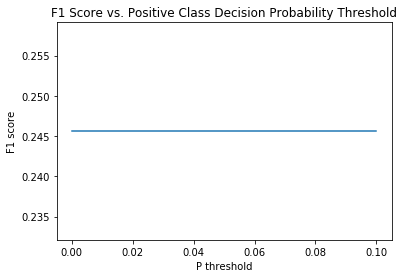

In [28]:
X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.00010,.10,1000)
model_val_probs = lr.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

#### SMOTE

In [29]:
smote = imblearn.over_sampling.SMOTE(\
                                     ratio={0:3085,1:415*7}, \
                                     random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train)

lr_smote = LogisticRegression(solver = 'lbfgs') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_smote.predict(X_test), y_test), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.000, Test AUC: 0.853


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


#### Undersampling

In [30]:
import imblearn.under_sampling

RUS = imblearn.under_sampling.RandomUnderSampler(\
                                     ratio={0:int(3085*.135),1:415}, \
                                     random_state = 42)
    
X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)

lr_RUS = LogisticRegression(solver = 'lbfgs') 
lr_RUS.fit(X_tr_RUS, y_tr_RUS)

print('Logistic Regression on Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
     (f1_score(lr_RUS.predict(X_test), y_test), roc_auc_score(y_test, lr_RUS.predict_proba(X_test)[:,1])))

Logistic Regression on Undersampled Train Data; Test F1: 0.000, Test AUC: 0.853


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


#### Class weights

In [64]:
###RERUN WITH PREVIOUS CELLS. RESULT SHOWN HERE ARE FOR CELLS THAT ARE FURTHER DOWN!!!!!
lr = LogisticRegression(solver = 'lbfgs') 
lr_balanced = LogisticRegression(class_weight='balanced')
lr_7x = LogisticRegression(class_weight={1 : 7, 0 : 1})

lr.fit(X_train, y_train)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_balanced.predict(X_test), y_test), roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1])))

lr_7x.fit(X_train, y_train)
print('3:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_7x.predict(X_test), y_test), roc_auc_score(y_test, lr_7x.predict_proba(X_test)[:,1])))

Normal Logistic Regression Test F1: 0.166, Test AUC: 0.887
Balanced class weights Logistic Regression Test F1: 0.530, Test AUC: 0.898
3:1 class weights Logistic Regression Test F1: 0.554, Test AUC: 0.900


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Model best F1 score 0.578 at prob decision threshold >= 0.592


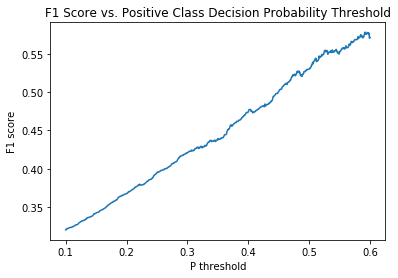

In [66]:
X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,0.6,1000)
model_val_probs = lr_balanced.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

**It could mean you picked a lousy cut off point for your model. F1 uses a specific cut off point which should be chosen wisely.
Also for highly imbalanced data it can be very difficult to get high recall on the rare class with reasonable precision.
AUC for better or worse is indifferent to class imbalance. You can have fairly good separation but still be unable to solve the problem for your use case simply because identifying very rare instances is hard.**

### Log transform x

In [198]:
X_log = np.log2(X)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log2
  """Entry point for launching an IPython kernel.


In [199]:
X_log.head()

,moment1,moment2,moment3,moment4,moment5,moment6,moment7
0,-8.762041,-25.551562,-33.113378,-33.850156,NaN,-46.626310,-67.557054
1,-8.306910,-24.039439,-32.126936,-34.881253,NaN,NaN,NaN
2,-8.794929,-23.704710,-36.056845,-34.348154,NaN,NaN,NaN
3,-8.691208,-24.648885,-43.534630,-37.507693,NaN,-49.832159,-79.370833
4,-8.885618,-25.864326,-33.930737,-34.501567,NaN,-49.108176,-70.468305


In [200]:
X_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
moment1    5000 non-null float64
moment2    5000 non-null float64
moment3    5000 non-null float64
moment4    5000 non-null float64
moment5    2617 non-null float64
moment6    2770 non-null float64
moment7    2517 non-null float64
dtypes: float64(7)
memory usage: 273.5 KB


In [201]:
X_log.describe()

,moment1,moment2,moment3,moment4,moment5,moment6,moment7
count,5000.000000,5000.000000,5000.000000,5000.000000,2617.000000,2770.000000,2517.000000
mean,-9.537167,-30.388264,-39.482750,-40.343757,-80.739101,-55.160387,-81.227788
std,0.674795,5.789218,6.233336,6.357237,12.435289,8.929968,12.536506
min,-10.515576,-55.440536,-65.700143,-62.774521,-120.737261,-87.413581,-121.587036
25%,-10.259682,-32.108775,-41.576551,-42.603769,-84.955954,-57.943375,-85.470512
50%,-9.441924,-28.914882,-37.857277,-38.837390,-77.754205,-53.092508,-78.223637
75%,-9.043009,-26.525558,-35.255924,-35.962011,-72.288610,-49.078274,-72.605226
max,-7.713399,-20.114633,-28.080260,-28.980998,-59.611815,-39.068956,-59.389202


In [202]:
df_log = X_log.join(y)

In [203]:
df_log.head()

,moment1,moment2,moment3,moment4,moment5,moment6,moment7,y
0,-8.762041,-25.551562,-33.113378,-33.850156,NaN,-46.626310,-67.557054,1
1,-8.306910,-24.039439,-32.126936,-34.881253,NaN,NaN,NaN,1
2,-8.794929,-23.704710,-36.056845,-34.348154,NaN,NaN,NaN,1
3,-8.691208,-24.648885,-43.534630,-37.507693,NaN,-49.832159,-79.370833,1
4,-8.885618,-25.864326,-33.930737,-34.501567,NaN,-49.108176,-70.468305,1


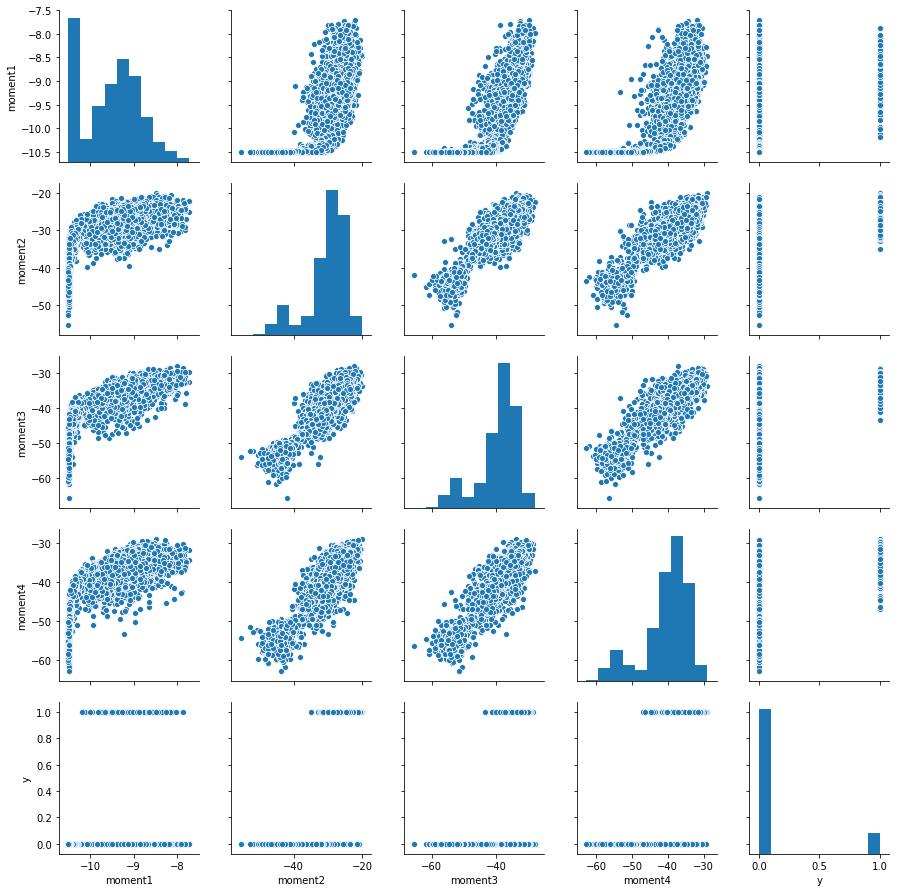

In [40]:
sns.pairplot(df_log)

In [204]:
df_log =df_log.drop(columns = ['moment5','moment6', 'moment7', "y"])
#df_log =df_log.drop(columns = ['y'])

In [205]:
df_log.head()

,moment1,moment2,moment3,moment4
0,-8.762041,-25.551562,-33.113378,-33.850156
1,-8.306910,-24.039439,-32.126936,-34.881253
2,-8.794929,-23.704710,-36.056845,-34.348154
3,-8.691208,-24.648885,-43.534630,-37.507693
4,-8.885618,-25.864326,-33.930737,-34.501567


In [206]:
X_train, X_test, y_train, y_test = train_test_split(df_log, y, test_size = 0.3, random_state=42)

In [207]:
X_train.head()

,moment1,moment2,moment3,moment4
1840,-9.447535,-29.150558,-38.895326,-39.325992
2115,-7.929377,-24.287552,-31.120180,-34.595878
4437,-10.508920,-42.660495,-52.909291,-55.064213
1146,-9.131673,-28.113419,-37.318701,-36.243054
2486,-8.182503,-21.445026,-31.649517,-31.528274


#### Oversampling

In [208]:
# randomly oversample by telling it the number of samples to have in each class
ROS_log = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:3085,1:415*7}, \
                                               random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

lr = LogisticRegression(solver = 'lbfgs') 
lr.fit(X_train, y_train)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

lr_os = LogisticRegressionCV(solver = 'lbfgs') 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_test), y_test), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))

Simple Logistic Regression; Test F1: 0.346, Test AUC: 0.901
Logistic Regression on Oversampled Train Data; Test F1: 0.564, Test AUC: 0.901


In [1]:
# randomly oversample by telling it the number of samples to have in each class
ROS_log = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:3085,1:415*7}, \
                                               random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

lr = LogisticRegressionCV(solver = 'lbfgs', cv=10) 
lr.fit(X_train, y_train)

print('Simple Logistic Regression CV; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))) 

print('Simple Logistic Regression CV; Train F1: %.3f, Train AUC: %.3f' % \
      (f1_score(lr.predict(X_train), y_train), roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))) 

lr_os = LogisticRegressionCV(solver = 'lbfgs', cv=10) 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression CV on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_test), y_test), roc_auc_score(y_test, lr_os.predict_proba(X_test)[:,1])))

NameError: name 'imblearn' is not defined

In [278]:
pkl.dump(lr_os, open('predict_tumor.p', 'wb'))

In [282]:
lr_os

ValueError: Expected 2D array, got 1D array instead:
array=[1 2 3 4].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [174]:
test_logistic(X_train, y_train, X_test, y_test)

Simple Logistic Regression; Test F1: 0.346, Test AUC: 0.901


In [175]:
test_logistic_oversampling(X_train, y_train, X_test, y_test)

Logistic Regression on Oversampled Train Data; Test F1: 0.564, Test AUC: 0.901


In [144]:
cross_val_score(lr,X_train,y_train,cv=5,scoring='accuracy').mean()

0.8854285714285715

In [145]:
cross_val_score(lr_os,X_train,y_train,cv=5,scoring='accuracy').mean()

0.8854285714285715

In [105]:
# Look at the coefficient and intercept of the Simple Logistic model:
lr.coef_, lr.intercept_

(array([[0.84284252, 0.20183491, 0.17962419, 0.16336149]]),
 array([23.70544719]))

In [107]:
# Look at the coefficient and intercept of the Simple Logistic model:
lr_os.coef_, lr_os.intercept_

(array([[1.57105214, 0.22511825, 0.19484495, 0.15847309]]),
 array([33.18485601]))

In [146]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_train, lr.predict(X_train))

array([[2987,   98],
       [ 304,  111]])

In [147]:
lr.predict(X_train)

array([0, 1, 0, ..., 0, 0, 0])

In [149]:
a = lr.predict_proba(X_train)

In [150]:
a[1][0]

0.29347136798205953

In [109]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_test, lr.predict(X_test))

array([[1251,   39],
       [ 158,   52]])

In [110]:
#Confusion matrix for the oversampled Logistic
confusion_matrix(y_train, lr_os.predict(X_train))

array([[2472,  613],
       [  63,  352]])

In [111]:
confusion_matrix(y_test, lr_os.predict(X_test))

array([[1047,  243],
       [  32,  178]])

In [272]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', cbar = False,
           xticklabels=['Not Tumor', 'Tumor'],
           yticklabels=['Not Tumor', 'Tumor']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

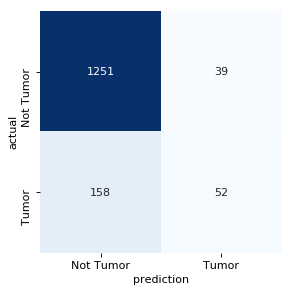

In [273]:
make_confusion_matrix(lr)
plt.savefig('log.png')

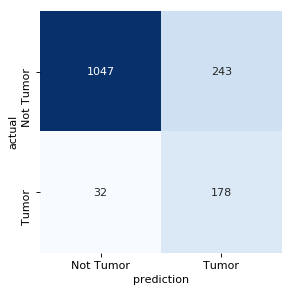

In [274]:
make_confusion_matrix(lr_os)
plt.savefig('log_os.png',)

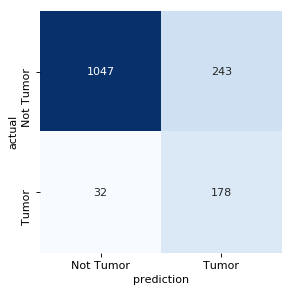

In [275]:
make_confusion_matrix(lr_os, threshold = 0.5)

In [276]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z = [[32,  178],[1047,  243]],
                   x = ['Not Tumor', 'Tumor'],
                  y = ['Tumor', 'Not Tumor'])

layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=go.layout.Margin(
        l=100,
        r=50,
        b=100,
        t=100,
        pad=4,
)
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-heatmap')
#py.iplot(data, filename='basic-heatmap')

In [244]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr_os, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

Logistic Regression Model best F1 score 0.610 at prob decision threshold >= 0.244


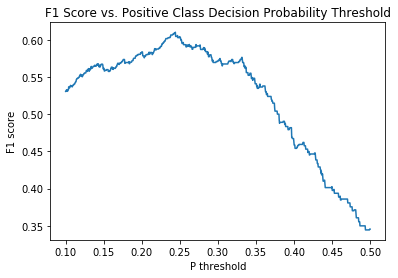

In [112]:
best_F1_finder(0.1,0.5, lr)

Logistic Regression Model best F1 score 0.603 at prob decision threshold >= 0.676


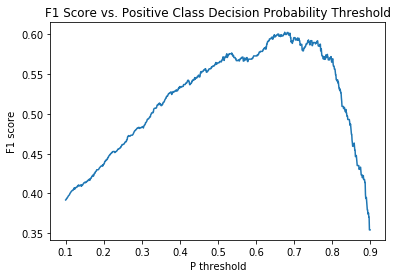

In [114]:
best_F1_finder(0.1,0.9, lr_os)

#### High C low regularization

In [239]:
ROS_log = imblearn.over_sampling.RandomOverSampler(\
                                               ratio={0:3085,1:415*7}, \
                                               random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

lr_C = LogisticRegression(solver = 'lbfgs', C=1000) 
lr_C.fit(X_train, y_train)

print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_C.predict(X_test), y_test), roc_auc_score(y_test, lr_C.predict_proba(X_test)[:,1]))) 

lr_os_C = LogisticRegression(solver = 'lbfgs', C=1000) 
lr_os_C.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os_C.predict(X_test), y_test), roc_auc_score(y_test, lr_os_C.predict_proba(X_test)[:,1])))

Simple Logistic Regression; Test F1: 0.344, Test AUC: 0.901
Logistic Regression on Oversampled Train Data; Test F1: 0.564, Test AUC: 0.901


In [240]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_test, lr_C.predict(X_test))

array([[1250,   40],
       [ 158,   52]])

In [241]:
#Confusion matrix for the Simple Logistic
confusion_matrix(y_test, lr_os_C.predict(X_test))

array([[1047,  243],
       [  32,  178]])

In [243]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)
a = log_loss(y_test, dc.predict_proba(X_test))
b = log_loss(y_test, lr_os.predict_proba(X_test))
print(a,b)

7.782737614319874 0.40255798983984475


In [245]:
confusion_matrix(y_test, dc.predict(X_test))

array([[1124,  166],
       [ 191,   19]])

In [184]:
print("Logistic(Oversampled): ", lr_os.score(X_test, y_test))
print("Logistic: ", lr.score(X_test, y_test))
print("Dummy: ", dc.score(X_test, y_test))

Logistic(Oversampled):  0.8166666666666667
Logistic:  0.8686666666666667
Dummy:  0.7833333333333333


#### SMOTE

In [115]:
smote = imblearn.over_sampling.SMOTE(\
                                     ratio={0:3085,1:415*7}, \
                                     random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train)

lr_smote = LogisticRegression(solver = 'lbfgs') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_smote.predict(X_test), y_test), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.565, Test AUC: 0.900


In [116]:
#Confusion matrix for the oversampled Logistic
confusion_matrix(y_train, lr_smote.predict(X_train))

array([[2484,  601],
       [  62,  353]])

Logistic Regression Model best F1 score 0.600 at prob decision threshold >= 0.665


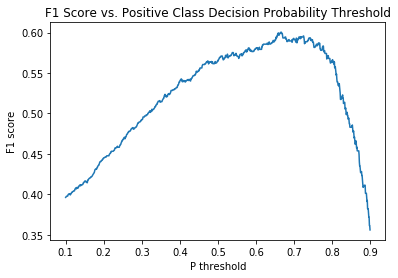

In [117]:
best_F1_finder(0.1, 0.9, lr_smote)

#### Undersampling

In [118]:
import imblearn.under_sampling

RUS = imblearn.under_sampling.RandomUnderSampler(\
                                     ratio={0:int(3085*.135),1:415}, \
                                     random_state = 42)
    
X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)

lr_RUS = LogisticRegression(solver = 'lbfgs') 
lr_RUS.fit(X_tr_RUS, y_tr_RUS)

print('Logistic Regression on Undersampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
     (f1_score(lr_RUS.predict(X_test), y_test), roc_auc_score(y_test, lr_RUS.predict_proba(X_test)[:,1])))

Logistic Regression on Undersampled Train Data; Test F1: 0.555, Test AUC: 0.901


In [119]:
confusion_matrix(y_train, lr_RUS.predict(X_train))

array([[2425,  660],
       [  53,  362]])

In [120]:
confusion_matrix(y_test, lr_RUS.predict(X_test))

array([[1029,  261],
       [  29,  181]])

Logistic Regression Model best F1 score 0.602 at prob decision threshold >= 0.672


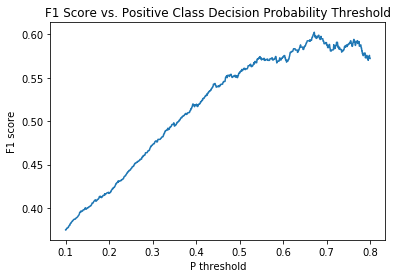

In [121]:
best_F1_finder(.1, .8, lr_RUS)

#### Class weights

In [122]:
lr = LogisticRegression(solver ='lbfgs') 
lr_balanced = LogisticRegression(class_weight='balanced',solver ='lbfgs')
lr_7x = LogisticRegression(class_weight={1 : 7, 0 : 1}, solver ='lbfgs')

lr.fit(X_train, y_train)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_test), y_test), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_balanced.predict(X_test), y_test), roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1])))

lr_7x.fit(X_train, y_train)
print('3:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_7x.predict(X_test), y_test), roc_auc_score(y_test, lr_7x.predict_proba(X_test)[:,1])))

Normal Logistic Regression Test F1: 0.346, Test AUC: 0.901
Balanced class weights Logistic Regression Test F1: 0.565, Test AUC: 0.901
3:1 class weights Logistic Regression Test F1: 0.559, Test AUC: 0.901


Logistic Regression Model best F1 score 0.610 at prob decision threshold >= 0.244


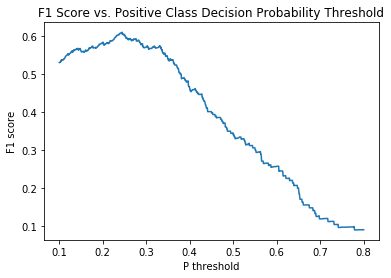

In [123]:
best_F1_finder(.1, .8, lr)

Logistic Regression Model best F1 score 0.602 at prob decision threshold >= 0.681


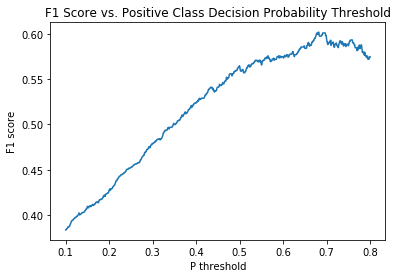

In [124]:
best_F1_finder(.1, .8, lr_balanced)

Logistic Regression Model best F1 score 0.602 at prob decision threshold >= 0.668


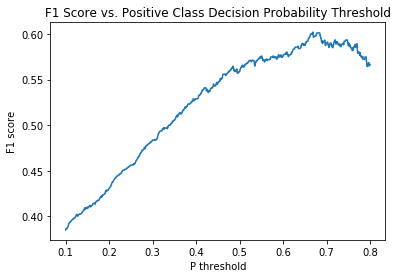

In [125]:
best_F1_finder(.1, .8, lr_7x)

### KNN 

In [126]:
from sklearn.neighbors import KNeighborsClassifier

# fit on train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [128]:
from sklearn import metrics
# test on test
y_pred = knn.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.884


In [129]:
confusion_matrix(y_test,y_pred)

array([[1239,   51],
       [ 123,   87]])

**KNN model seems to perform poorly as compared to the LR model. Some of the things we can try:**

**1. DO a Grid search CV for a range of k values.**

**2. Try out with the normal scaled data and see if KNN makes a difference, rather than using log transformed data.**

**3. **

In [131]:
# define the parameter values that should be searched
k_range = list(range(1, 100))

In [132]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


In [133]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [134]:
# fit the grid with data
grid.fit(X_train, y_train);

In [136]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8928571428571429
{'n_neighbors': 11}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')


In [137]:
knn11 = KNeighborsClassifier(n_neighbors=11)
knn11.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')

In [139]:
y_pred = knn11.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.8873333333333333


In [140]:
confusion_matrix(y_test,y_pred)

array([[1249,   41],
       [ 128,   82]])

### Naive Bayes